In [ ]:
# Setup

# Install packages
!pip install smartapi-python
!pip install logzero
!pip install pyotp
!pip install websocket-client
!pip install ijson

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/

# Set time zone to IST
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Kolkata /etc/localtime
!date


In [9]:

# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
from datetime import time, timedelta, datetime
import ijson
import json
import time
import requests
import pandas as pd
from talib.abstract import *

In [11]:
# Functions

def login(api_key, token, username, pwd):

    smartApi = SmartConnect(api_key)
    try:
        totp = pyotp.TOTP(token).now()
    except Exception as e:
        logger.error("Invalid Token: The provided token is not valid.")
        raise e

    correlation_id = "abcde"
    data = smartApi.generateSession(username, pwd, totp)


    if data['status'] == False:
        logger.error(data)

    else:
        # login api call
        # logger.info(f"You Credentials: {data}")
        authToken = data['data']['jwtToken']
        refreshToken = data['data']['refreshToken']
        # fetch the feedtoken
        feedToken = smartApi.getfeedToken()
        # fetch User Profile
        res = smartApi.getProfile(refreshToken)
        smartApi.generateToken(refreshToken)
        res=res['data']['exchanges']

    return smartApi

def fetch_price(exchange, symbol, token):
    data = smartApi.ltpData(exchange, symbol, token)
    return data['data']['ltp']

def to_nearest_point05(number):
    # Multiply by 20 to convert 0.05 steps to integer steps
    return round(number * 20) / 20

def find_nearest_expiry(url, strike_price):
    # Fetch the JSON data
    response = requests.get(url)
    data = json.loads(response.text)

    # Normalize the strike price
    normalized_strike = str(int(float(strike_price) * 100))

    # Separate lists for CE and PE options
    ce_options = []
    pe_options = []
    latest_ce = None
    latest_pe = None

    for entry in data:
        # Normalize the strike price from JSON
        json_strike = str(int(float(entry['strike'])))

        if (json_strike == normalized_strike and
            entry['exch_seg'] == "NFO" and
            entry['name'] == "NIFTY"):

            expiry_date = datetime.strptime(entry['expiry'], "%d%b%Y").date()

            if entry['symbol'][-2:] == "CE":
                if latest_ce is None or expiry_date < datetime.strptime(latest_ce['expiry'], "%d%b%Y").date():
                    latest_ce = entry
            elif entry['symbol'][-2:] == "PE":
                if latest_pe is None or expiry_date < datetime.strptime(latest_pe['expiry'], "%d%b%Y").date():
                    latest_pe = entry

    print(f"Latest CE: {latest_ce}")
    print(f"Latest PE: {latest_pe}")

    return {
        'CE': latest_ce,
        'PE': latest_pe
    }

def get_order_info(orderid):
    OrderBook = smartApi.orderBook()['data']
    for i in OrderBook:
        if i['orderid'] == orderid:
            return i

def trailing_stoploss(orderid_sl, trailing_stoploss, orderid): # trailing_stoploss =

    order_info_sl = get_order_info(orderid_sl)
    order_info = get_order_info(orderid)
    print(order_info_sl)

    new_stoploss = None

    symbol = order_info_sl['tradingsymbol']
    exchange = order_info_sl['exchange']
    token = order_info_sl['symboltoken']
    prev_price = order_info['averageprice']
    order_type = order_info_sl['transactiontype']
    prev_stoploss = order_info_sl['triggerprice']




    if order_type == "BUY":

        min_val = prev_price

        while True:

            curr_price = fetch_price(exchange, symbol, token)
            if curr_price < min_val:

                new_stoploss = prev_stoploss - (trailing_stoploss * (min_val - curr_price))
                modify_params = order_info_sl
                modify_params['triggerprice'] = to_nearest_point05(new_stoploss)
                modify_params['price'] = to_nearest_point05(new_stoploss * 1.05)
                smartApi.modifyOrder(modify_params)
                min_val = curr_price
                prev_stoploss = to_nearest_point05(new_stoploss)
                print("-----------STOPLOSS-------------")
                print(to_nearest_point05(new_stoploss))
                print("-----------STOPLOSS-------------")

            print("Curr price: ", curr_price)
            print("Min Val: ", min_val)
            time.sleep(15)


    else:

        max_val = prev_price

        while True:

            curr_price = fetch_price(exchange, symbol, token)
            if curr_price > max_val:

                new_stoploss = prev_stoploss + (trailing_stoploss * (curr_price - max_val))
                modify_params = order_info_sl
                modify_params['triggerprice'] = to_nearest_point05(new_stoploss)
                modify_params['price'] = to_nearest_point05(new_stoploss * .95)
                smartApi.modifyOrder(modify_params)
                max_val = curr_price

            time.sleep(15)


def get_historical_data(exc, token, interval, from_dt, to_dt):

    #Historic api
    try:
        historicParam={
        "exchange": exc,
        "symboltoken": token,
        "interval": interval,
        "fromdate": from_dt,
        "todate": to_dt
        }
        return smartApi.getCandleData(historicParam)
    except Exception as e:
        logger.exception(f"Historic Api failed: {e}")


In [ ]:
api_key = 'key'
username = 'user'
pwd = 'pwd'
token = "token"

smartApi = login(api_key, token, username, pwd)


In [ ]:

# Current time
now = datetime.now()
end = now.strftime("%Y-%m-%d %H:%M")

s_token = "3045"
exchange = "NSE"
s_symbol = "SBIN-EQ"

# Time 2 days ago
two_days_ago = now - timedelta(days=29)
start = two_days_ago.strftime("%Y-%m-%d %H:%M")
res = get_historical_data(exchange, s_token, "ONE_MINUTE", start, end)

cols = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
df = pd.DataFrame(res['data'], columns=cols)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['EMA'] = EMA(df.close, timeperiod=20)
df['RSI'] = RSI(df.close, timeperiod=14)
df['ATR'] = ATR(df.high, df.low, df.close, timeperiod=20)


df['Cross Up'] = df['Cross Down'] = df["RSI Up"] = 0
df = df.round(decimals=2)
df

for i in range(20, len(df)):
    # Cross Up
    if df['close'][i-1] <= df['EMA'][i-1] and df['close'][i] > df['EMA'][i]:
        df.loc[i, 'Cross Up'] = 1  # Use df.loc for assignment

    # Cross Down
    if df['close'][i-1] >= df['EMA'][i-1] and df['close'][i] < df['EMA'][i]:
        df.loc[i, 'Cross Down'] = 1  # Use df.loc for assignment

    # RSI Up
    if df['RSI'][i] > 50:
        df.loc[i, 'RSI Up'] = 1  # Use df.loc for assignment



# Backtesting
trades = []  # To store trade details
in_trade = False  # Flag to track if we are in a trade
entry_price = 0  # Entry price of the trade

for i in range(len(df)):
    # Buy Condition: Cross Up and RSI Up
    if not in_trade and df['Cross Up'][i] == 1 and df['RSI Up'][i] == 1:
        in_trade = True
        entry_price = df['close'][i]
        entry_time = df['timestamp'][i]

    # Sell Condition: Cross Down and RSI Up == 0
    if in_trade and df['Cross Down'][i] == 1 and df['RSI Up'][i] == 0:
        in_trade = False
        exit_price = df['close'][i]
        exit_time = df['timestamp'][i]

        # Calculate profit/loss
        pnl = exit_price - entry_price
        pnl_pct = (pnl / entry_price) * 100

        # Store trade details
        trades.append({
            'entry_time': entry_time,
            'exit_time': exit_time,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'pnl': pnl,
            'pnl_pct': pnl_pct
        })

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)

# Print trade results
print("Trade Results:")
print(trades_df)

# Calculate total PnL and win rate
total_pnl = trades_df['pnl'].sum()
total_pnl_pct = trades_df['pnl_pct'].sum()
win_rate = (trades_df['pnl'] > 0).mean() * 100

print(f"\nTotal PnL: {total_pnl:.2f}")
print(f"Total PnL (%): {total_pnl_pct:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")






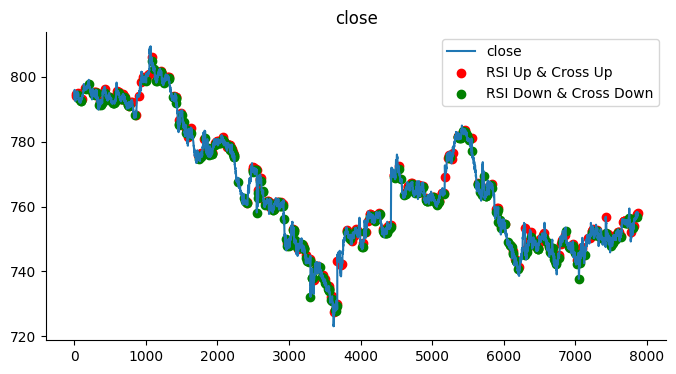

In [51]:
import matplotlib.pyplot as plt

# Plot the 'close' column
df['close'].plot(kind='line', figsize=(8, 4), title='close')

# Identify where both RSI_Up == 1 and cross_up == 1 in the same row
condition1 = (df['RSI Up'] == 1) & (df['Cross Up'] == 1)
condition2 = (df['RSI Up'] == 0) & (df['Cross Down'] == 1)

# Add markers where the condition is True
plt.scatter(df.index[condition1], df['close'][condition1], color='red', marker='o', label='RSI Up & Cross Up')
plt.scatter(df.index[condition2], df['close'][condition2], color='green', marker='o', label='RSI Down & Cross Down')

# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Add a legend
plt.legend()

# Show the plot
plt.show()